initial loading beta [[ 0.45408906 -0.81457369 -0.97043354  0.50102365 -0.65370189  0.07246586
  -0.37139602 -0.3975504   0.86108988 -0.30208269 -0.89072925]
 [-0.89091195  0.6092122  -0.9310372  -0.74634048 -0.24372732 -0.82048035
  -0.55666113  0.36258211  0.32512783 -0.29751321  0.97565791]
 [-0.28343855 -0.50477843  0.75817689  0.84991982  0.24595287 -0.79222779
   0.32605352 -0.2633455  -0.96485289 -0.28497074 -0.13428075]]


 12%|█▏        | 12/100 [00:00<00:06, 12.62it/s]

!!! pred_type filter
!!! --- Validation --- [confusion_mx, Accuracy] =  [array([[509,  31],
       [150,  30]], dtype=int64), 0.749]


 22%|██▏       | 22/100 [00:01<00:05, 13.27it/s]

!!! pred_type filter
!!! --- Validation --- [confusion_mx, Accuracy] =  [array([[504,  36],
       [146,  34]], dtype=int64), 0.747]


 32%|███▏      | 32/100 [00:02<00:05, 13.04it/s]

!!! pred_type filter
!!! --- Validation --- [confusion_mx, Accuracy] =  [array([[508,  32],
       [149,  31]], dtype=int64), 0.749]


 42%|████▏     | 42/100 [00:03<00:04, 12.28it/s]

!!! pred_type filter
!!! --- Validation --- [confusion_mx, Accuracy] =  [array([[507,  33],
       [152,  28]], dtype=int64), 0.743]


 52%|█████▏    | 52/100 [00:04<00:03, 12.95it/s]

!!! pred_type filter
!!! --- Validation --- [confusion_mx, Accuracy] =  [array([[506,  34],
       [153,  27]], dtype=int64), 0.74]


 62%|██████▏   | 62/100 [00:04<00:03, 11.63it/s]

!!! pred_type filter
!!! --- Validation --- [confusion_mx, Accuracy] =  [array([[506,  34],
       [154,  26]], dtype=int64), 0.739]


 72%|███████▏  | 72/100 [00:05<00:02, 11.60it/s]

!!! pred_type filter
!!! --- Validation --- [confusion_mx, Accuracy] =  [array([[505,  35],
       [153,  27]], dtype=int64), 0.739]


 82%|████████▏ | 82/100 [00:06<00:01, 11.75it/s]

!!! pred_type filter
!!! --- Validation --- [confusion_mx, Accuracy] =  [array([[502,  38],
       [155,  25]], dtype=int64), 0.732]


 92%|█████████▏| 92/100 [00:07<00:00, 11.32it/s]

!!! pred_type filter
!!! --- Validation --- [confusion_mx, Accuracy] =  [array([[503,  37],
       [156,  24]], dtype=int64), 0.732]


100%|██████████| 100/100 [00:08<00:00, 12.23it/s]


!!! pred_type filter
!!! FINAL [confusion_mx, Accuracy] =  [array([[518,  22],
       [167,  13]], dtype=int64), 0.738]
Accuracy: 0.5375
Confusion Matrix:
[[59  0  0  1]
 [ 0 28 15 17]
 [ 0 26 11 23]
 [ 0 14 15 31]]


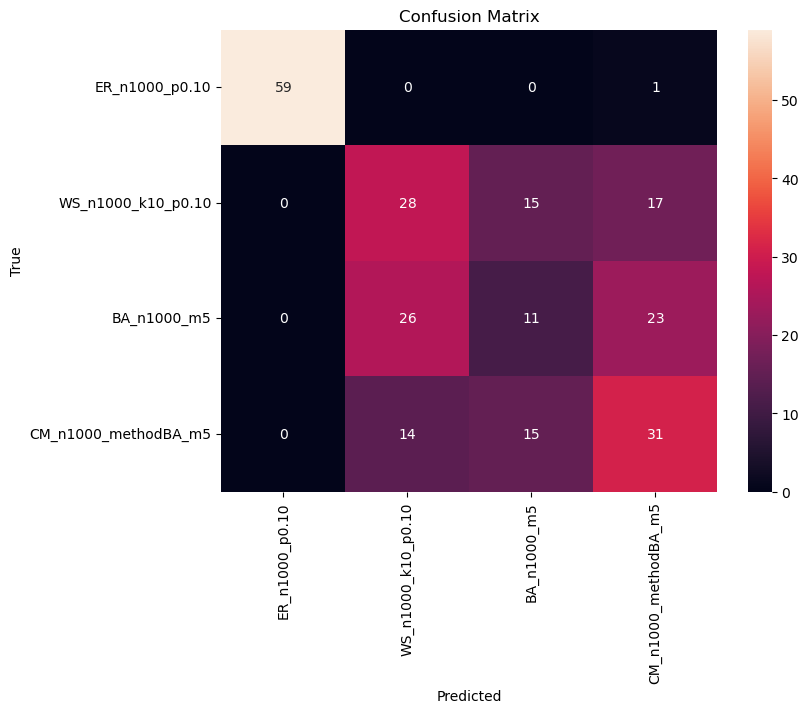

In [12]:
# Import necessary libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

# Adjust the path to include your custom modules
sys.path.append('/Users/yee/Research/REU_2024/REU2024_code/NNetwork_modified')
sys.path.append('/Users/yee/Research/REU_2024/REU2024_code/src')

# Import your NNetwork class
from NNetwork_modified.NNetwork import NNetwork as nn

# Import your existing functions
from src.sampling.Sampling import sampling_sndl as sampling_sndl_original
from src.supervised_NDL.SNDL import sndl_equalEdge as sndl_equalEdge_original
from src.supervised_NDL.SNDL import sndl_predict as sndl_predict_original
from src.supervised_NDL import SMF_BCD

# Suppress output context manager
from contextlib import contextmanager
@contextmanager
def suppress_output():
    with open(os.devnull, 'w') as fnull:
        original_stdout = sys.stdout
        sys.stdout = fnull
        try:
            yield
        finally:
            sys.stdout = original_stdout

# Define your modified functions, avoiding name conflicts

def sampling_sndl_multi(list_graphs: list, 
                        k=20, 
                        sample_size_list=None, 
                        sample_size=200,
                        sampling_alg='pivot',  # 'RW'
                        skip_folded_hom=True):
    '''
    Modified sampling_sndl function to handle multi-class labels.
    '''
    len_networks = len(list_graphs)
    X_list = []
    y_list = []

    if sample_size_list is None:
        sample_size_list = [sample_size] * len_networks

    for idx, G in enumerate(list_graphs):
        sample_size = sample_size_list[idx]
        if sampling_alg != 'RW':
            X, _ = G.get_patches(k=k, sample_size=sample_size,
                                 sampling_alg=sampling_alg,
                                 skip_folded_hom=skip_folded_hom)
            X_list.append(X)
        else:
            # RW sampling code (if needed)
            pass  # Implement if required

        # Construct one-hot encoded labels
        real_sample_size = X.shape[1]
        y = np.zeros(len_networks)
        y[idx] = 1
        y_matrix = np.tile(y, (real_sample_size, 1)).T
        y_list.append(y_matrix)

    X_all = np.concatenate(X_list, axis=1)
    y_all = np.concatenate(y_list, axis=1)

    return X_all, y_all

def sndl_predict_samples(X, W, beta):
    '''
    Modified sndl_predict function to handle multi-class predictions.
    '''
    n_samples = X.shape[1]
    n_classes = beta.shape[0] + 1  # Including class 0
    prob_matrix = np.zeros((n_classes, n_samples))

    for i in range(n_samples):
        x_i = X[:, i]
        exponent = beta[:, 1:] @ (W.T @ x_i) + beta[:, 0]
        exp_exponent = np.exp(exponent)
        normalizer = 1 + np.sum(exp_exponent)
        p = exp_exponent / normalizer
        prob = np.insert(p, 0, 1 - np.sum(p))  # Class 0 probability
        prob_matrix[:, i] = prob

    return prob_matrix

def train_sndl_model(X_train, y_train, xi, n_components, iterations, X_test, y_test):
    '''
    Function to train the SNDL model using your existing code.
    '''
    # Adjust labels for the model (exclude class 0)
    y_train_model = y_train[1:, :]  # Exclude the first row (class 0)
    y_test_model = y_test[1:, :]    # Exclude the first row (class 0)

    SMF_Train = SMF_BCD.SDL_BCD([X_train, y_train_model], X_test=[X_test, y_test_model], xi=xi, n_components=n_components)
    results_dict = SMF_Train.fit(
        iter=iterations,
        subsample_size=None,
        if_compute_recons_error=False,
        if_validate=True,  # Set to True to enable validation
        threshold=0.5
    )

    W = results_dict.get('loading')[0]
    beta = results_dict.get('loading')[1]

    return W, beta

def compute_accuracy_and_cm(W, beta, X_test, y_test_labels):
    '''
    Compute accuracy and confusion matrix using the trained model.
    '''
    prob_matrix = sndl_predict_samples(X_test, W, beta)
    y_pred_labels = np.argmax(prob_matrix, axis=0)

    acc = accuracy_score(y_test_labels, y_pred_labels)
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=range(len(ntwk_list)))

    return acc, cm, y_pred_labels

# Main Execution Flow

# Define your network list
ntwk_list = ['ER_n1000_p0.10', 'WS_n1000_k10_p0.10', 'BA_n1000_m5', 'CM_n1000_methodBA_m5']
sample_size = 300   # Number of subgraphs per network
k = 30              # Size of each subgraph (number of nodes)
xi = 5              # Sparsity parameter
n_components = 10   # Number of dictionary components
iterations = 100    # Number of iterations
skip_folded_hom = False

# Load graphs and sample subgraphs with labels
graph_list = []
for ntwk in ntwk_list:
    path = f"data/{ntwk}.txt"
    G = nn()
    G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
    graph_list.append(G)

# Sample subgraphs and get labels
X_all, y_all = sampling_sndl_multi(graph_list, k=k, sample_size=sample_size, skip_folded_hom=skip_folded_hom)

# Convert one-hot labels to integer labels for evaluation
y_labels = np.argmax(y_all.T, axis=1)

# Use StratifiedShuffleSplit to get consistent indices
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in sss.split(X_all.T, y_labels):
    X_train = X_all[:, train_index]
    X_test = X_all[:, test_index]
    y_train = y_all[:, train_index]
    y_test_labels = y_labels[test_index]
    y_test = y_all[:, test_index]

# Train the model
W, beta = train_sndl_model(X_train, y_train, xi=xi, n_components=n_components, iterations=iterations,
                           X_test=X_test, y_test=y_test)

# Test the model
acc, cm, y_pred_labels = compute_accuracy_and_cm(W, beta, X_test, y_test_labels)

# Print results
print(f"Accuracy: {acc}")
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=ntwk_list, yticklabels=ntwk_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
